In [1]:
#导入相关依赖库
import os
import numpy as np
from matplotlib import pyplot as plt
import mindspore as ms
#context 模块用于设置实验环境和实验设备
import mindspore.context as context
#dataset 模块用于处理数据形成数据集
import mindspore.dataset as ds
#c_transforms 模块用于转换数据类型
import mindspore.dataset.transforms.c_transforms as C
#vision.c_transforms 模块用于转换图像，这是一个基于 opencv 的高级 API
import mindspore.dataset.vision.c_transforms as CV
#导入 Accuracy 作为评价指标
from mindspore.nn.metrics import Accuracy
#nn 中有各种神经网络层如：Dense，ReLu
from mindspore import nn
#Model 用于创建模型对象，完成网络搭建和编译，并用于训练和评估
from mindspore.train import Model
#LossMonitor 可以在训练过程中返回 LOSS 值作为监控指标
from mindspore.train.callback import LossMonitor
#设定运行模式为动态图模式，并且运行设备为昇腾芯片,CPU 运行时需要将 Ascend 改为 CPU
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

In [3]:
#MindSpore 内置方法读取 MNIST 数据集
ds_train = ds.MnistDataset(os.path.join(r'MNIST', "train"))
ds_test = ds.MnistDataset(os.path.join(r'MNIST', "test")) 
print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
#该数据集可以通过 create_dict_iterator()转换为迭代器形式，然后通过__next__()一个个输出样本
image=ds_train.create_dict_iterator().__next__()
print(type(image))
print('图像长/宽/通道数：',image['image'].shape)
#一共 10 类，用 0-9 的数字表达类别。
print('一张图像的标签样式：',image['label'])

训练数据集数量： 60000
测试数据集数量： 10000
<class 'dict'>
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 9


In [5]:
DATA_DIR_TRAIN = "MNIST/train" # 训练集信息
DATA_DIR_TEST = "MNIST/test" # 测试集信息
def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, 
buffer_size=64):
 ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
 
 #定义改变形状、归一化和更改图片维度的操作
#改为（28,28）的形状
 resize_op = CV.Resize(resize)
 #rescale 方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到 0 和 1 之间，shift 参数可以让值域偏移至-0.5 和 0.5 之间
 rescale_op = CV.Rescale(rescale, shift)
 #由高度、宽度、深度改为深度、高度、宽度
 hwc2chw_op = CV.HWC2CHW()
 
 # 利用 map 操作对原数据集进行调整
 ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
 ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
 #设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
 ds = ds.shuffle(buffer_size=buffer_size)
 #设定数据集的 batch_size 大小，并丢弃剩余的样本
 ds = ds.batch(batch_size, drop_remainder=True)
 
 return ds

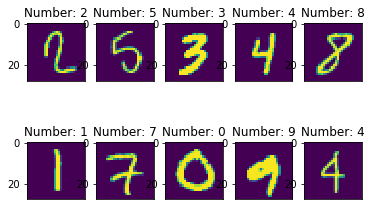

In [6]:
#显示前 10 张图片以及对应标签,检查图片是否是正确的数据集
dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
for i in range(1,11):
 plt.subplot(2, 5, i)
 #利用 squeeze 方法去掉多余的一个维度
 plt.imshow(np.squeeze(images[i]))
 plt.title('Number: %s' % labels[i])
 plt.xticks([])
plt.show()

In [7]:
#利用定义类的方式生成网络，Mindspore 中定义网络需要继承 nn.cell。在 init 方法中定义该网络需要的神经网络层
#在 construct 方法中梳理神经网络层与层之间的关系。
class ForwardNN(nn.Cell): 
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output) 
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output

In [8]:
lr = 0.001
num_epoch = 10
momentum = 0.9
net = ForwardNN()
#定义 loss 函数，改函数不需要求导，可以给离散的标签值，且 loss 值为均值
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
#定义准确率为评价指标，用于评价模型
metrics={"Accuracy": Accuracy()}
#定义优化器为 Adam 优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)

In [9]:
#生成验证集，验证机不需要训练，所以不需要 repeat
ds_eval = create_dataset(False, batch_size=32)
#模型编译过程，将定义好的网络、loss 函数、评价指标、优化器编译
model = Model(net, loss, opt, metrics)
#生成训练集
ds_train = create_dataset(True, batch_size=32)
print("============== Starting Training ==============")
#训练模型，用 loss 作为监控指标，并利用昇腾芯片的数据下沉特性进行训练
model.train(num_epoch, ds_train,callbacks=[LossMonitor()],dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.587862491607666
epoch: 2 step: 1875, loss is 1.6534266471862793
epoch: 3 step: 1875, loss is 1.5187777280807495
epoch: 4 step: 1875, loss is 1.6168296337127686
epoch: 5 step: 1875, loss is 1.5861526727676392
epoch: 6 step: 1875, loss is 1.6141473054885864
epoch: 7 step: 1875, loss is 1.5860952138900757
epoch: 8 step: 1875, loss is 1.6488769054412842
epoch: 9 step: 1875, loss is 1.5484519004821777
epoch: 10 step: 1875, loss is 1.5549001693725586


In [10]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

{'Accuracy': 0.8972355769230769}
